Model accuracies:

0.783

 Distribution parameters:

0.3174153944860996 1.9253445162344542
0.8545207861030307 2.065649467504403


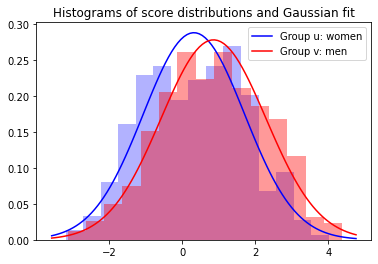

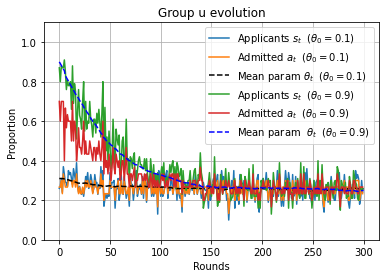

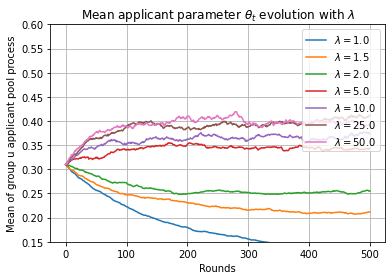

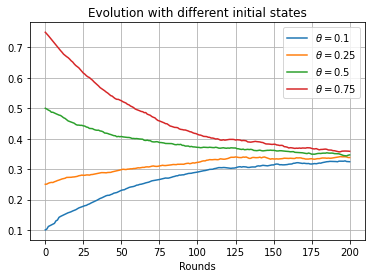

In [7]:
import aif360.datasets as ds
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from fairness_utils import *


# Adapting real-world datasets to get the score distributions and apply fairness framework

# German credit dataset pre-processing
label_map = {1.0: 'Good Credit', 0.0: 'Bad Credit'}
gd = ds.GermanDataset()
gd.labels[gd.labels == 2] = 0

sensitive_attr = 'sex' # or 'age'

if sensitive_attr == 'sex':
    col_idx = 0
else:
    col_idx = 1
    
idx_u = gd.protected_attributes[:,col_idx]==0
idx_v = gd.protected_attributes[:,col_idx]==1

features_u = gd.features[idx_u]
features_v = gd.features[idx_v]
labels_u = np.ravel(gd.labels[idx_u])
labels_v = np.ravel(gd.labels[idx_v])

Nu = len(labels_u)
Nv = len(labels_v)

features = gd.features
labels = np.ravel(gd.labels)

use_sensitive_attr = 1

if use_sensitive_attr == 1:

    # Using the sensitive attribute
    model = LogisticRegression(max_iter = 1000)
    model.fit(features, labels)
    fit_accuracy = model.score(features, labels)
    score = model.coef_@features.T
    print('Model accuracies:\n')
    print(fit_accuracy)

    score = np.ravel(score)
    score_u = score[idx_u]
    score_v = score[idx_v]

    mean_u,std_u=norm.fit(score_u.flatten())
    mean_v,std_v=norm.fit(score_v.flatten())
    print('\n Distribution parameters:\n')
    print(mean_u,std_u*std_u)
    print(mean_v,std_v*std_v)

    plt.figure()
    plt.hist(score_u.flatten(), bins = 15, density=True, alpha = 0.3, color = 'blue')
    plt.hist(score_v.flatten(), bins = 15, density = True, alpha = 0.4, color = 'red')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y_u = norm.pdf(x, mean_u, std_u)
    y_v = norm.pdf(x, mean_v, std_v)

    plt.plot(x, y_u, color = 'blue', label = 'Group u: women')
    plt.plot(x, y_v, color = 'red', label = 'Group v: men')
    plt.legend()
    plt.title('Histograms of score distributions and Gaussian fit')
    
else:
    # Without using the sensitive attribute
    from sklearn.linear_model import LogisticRegression
    if sensitive_attr == 'sex':
        xx = gd.features
        xx1 = xx[:,8:]
        xx2 = xx[:,0:7] 

    if sensitive_attr == 'age':
        xx = gd.features
        xx1 = xx[:,5:]
        xx2 = xx[:,0:4] 

    features = np.append(xx1,xx2, axis=1) # Without the use of gender
    labels = np.ravel(gd.labels)

    model = LogisticRegression(max_iter = 1000)
    model.fit(features, labels)
    fit_accuracy = model.score(features, labels)
    score = model.coef_@features.T
 
    score = np.ravel(score)
    score_u = score[idx_u]
    score_v = score[idx_v]

    mean_u,std_u=norm.fit(score_u.flatten())
    mean_v,std_v=norm.fit(score_v.flatten())
    print('\n Distribution parameters:\n')
    print(mean_u,std_u*std_u)
    print(mean_v,std_v*std_v)

    plt.figure()
    plt.hist(score_u.flatten(), bins = 20, density=True, alpha = 0.3, color = 'blue')
    plt.hist(score_v.flatten(), bins = 20, density = True, alpha = 0.4, color = 'red')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y_u = norm.pdf(x, mean_u, std_u)
    y_v = norm.pdf(x, mean_v, std_v)

    plt.plot(x, y_u, color = 'blue')
    plt.plot(x, y_v, color = 'red')

    plt.show()
    
    
# MDP settings
s_bar = 0.5
a_bar = 0.3
N = 100 
lambda_ = 2
eta = 0.025
theta_init = len(labels_u)/(len(labels_u)+len(labels_v)) #Initial mean of arrival process for number of minority applicants

dist_type = 'gaussian'


# Generate reward table:
state_space = np.arange(N+1)
greedy_reward_table = np.zeros((N+1,int(N*a_bar)+1))

for i in range(len(state_space)):
    greedy_reward_table[i,:] = get_greedy_reward(dist_type, mean_u, std_u, mean_v, std_v, N, a_bar, state_space[i]/N)
    
'''
num_rounds = 300

num_insts = 1
set_applicants_u = []
set_admitted_u = []
set_theta_vec = []
set_applicants_u2 = []
set_admitted_u2 = []
set_theta_vec2 = []

two_init_points = 1

for i in range(num_insts):
    if two_init_points == 0:
        applicants, admitted, theta_vec, overall_rew = process_evolution(theta_init, lambda_, eta, N, a_bar, s_bar, greedy_reward_table, num_rounds)
    else:
        theta_init2 = 0.9

        applicants_u, admitted_u, theta_vec, ov_rew = process_evolution(theta_init, lambda_, eta, N, a_bar, s_bar, greedy_reward_table, num_rounds)
        applicants_u2, admitted_u2, theta_vec2, ov_rew2 = process_evolution(theta_init2, lambda_, eta, N, a_bar, s_bar, greedy_reward_table, num_rounds)
        set_applicants_u.append(applicants_u)
        set_admitted_u.append(admitted_u)
        set_theta_vec.append(theta_vec)
        set_applicants_u2.append(applicants_u2)
        set_admitted_u2.append(admitted_u2)
        set_theta_vec2.append(theta_vec2)
        
sum_applicants_u = 0
sum_admitted_u = 0
sum_theta_vec = 0
sum_applicants_u2 = 0
sum_admitted_u2 = 0
sum_theta_vec2 = 0
for i in range(num_insts):
    sum_applicants_u = sum_applicants_u + set_applicants_u[i]
    sum_admitted_u = sum_admitted_u + set_admitted_u[i]
    sum_theta_vec = sum_theta_vec + set_theta_vec[i]
    sum_applicants_u2 = sum_applicants_u2 + set_applicants_u2[i]
    sum_admitted_u2 = sum_admitted_u2 + set_admitted_u2[i]
    sum_theta_vec2 = sum_theta_vec2 + set_theta_vec2[i]
sum_applicants_u = sum_applicants_u/num_insts
sum_admitted_u = sum_admitted_u/num_insts
sum_theta_vec = sum_theta_vec/num_insts
sum_applicants_u2 = sum_applicants_u2/num_insts
sum_admitted_u2 = sum_admitted_u2/num_insts
sum_theta_vec2 = sum_theta_vec2/num_insts
        
    
plt.figure()

lw = 1.5
lw2 = 2
plt.plot(sum_applicants_u, '-', label='Applicants ' +r'$s_t$  ($\theta_0 = 0.1$)', linewidth=lw)
plt.plot(sum_admitted_u, '-', label='Admitted ' +r'$a_t$  ($\theta_0 = 0.1$)', linewidth=lw)
plt.plot(sum_theta_vec, '--k', label='Mean param ' +r'$\theta_t$  ($\theta_0 = 0.1$)', linewidth=lw)
plt.plot(sum_applicants_u2, '-', label='Applicants ' +r'$s_t$  ($\theta_0 = 0.9$)', linewidth=lw)
plt.plot(sum_admitted_u2, '-', label='Admitted ' +r'$a_t$  ($\theta_0 = 0.9$)', linewidth=lw)
plt.plot(sum_theta_vec2, '--b', label='Mean param  ' +r'$\theta_t$  ($\theta_0 = 0.9$)', linewidth=lw)
plt.title('Group u evolution')
plt.grid()
plt.xlabel('Rounds')
plt.ylabel('Proportion')
plt.legend(loc=1, prop={'size': 10})
plt.ylim((0,1.1))
plt.xlim()'''

lambda_vec = np.array([1,1.5, 2, 5, 10, 25, 50])

plt.figure()
for i in range(len(lambda_vec)):
    lambda_ = lambda_vec[i]
    applicants_u, admitted_u, theta_vec, rr = process_evolution(theta_init, lambda_,eta, N, a_bar, s_bar, greedy_reward_table, 500)
    lambda_str = r'$\lambda = $'  + str(lambda_)
    plt.plot(theta_vec, label=lambda_str)
    
plt.title('Mean applicant parameter ' + r'$\theta_t$'+ ' evolution with ' + r'$\lambda$')
plt.grid()
plt.xlabel('Rounds')
plt.ylabel('Mean of group u applicant pool process')
plt.legend(loc=1)   
plt.ylim((0.15,0.6))


